# Lab 12 - Creating an End-To-End Dialogue System


In the last lab we want to create end-to-end dialogue systems, following on from the seq2seq MT labs you've done. Customer support apps and online helpdesks are among the places where conversational models can be used. Retrieval-based models, which produce predefined responses to questions of specific types, are often used to power these models. In this lab, the seq2seq model is used to build a generative model.

In [16]:
!git clone https://github.com/msolurenjr/Dialogue_Model_Cornell_MovieDialogs_Corpus_Seq2SeqWAttention.git

Cloning into 'Dialogue_Model_Cornell_MovieDialogs_Corpus_Seq2SeqWAttention'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 20 (delta 0), reused 7 (delta 0), pack-reused 13
Unpacking objects: 100% (20/20), done.


In [17]:
import re
import sys
import os
import random
import string
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, Concatenate, Lambda
np.random.seed(1)
random.seed(1)

In [3]:
# from google.colab import drive

# drive.mount('/content/drive', force_remount=True)

# os.chdir("/content/drive/My Drive")

Mounted at /content/drive


## Download Cornell Movie Dialogs Corpus

In [2]:
!wget http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip

--2022-05-06 16:01:07--  http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9916637 (9.5M) [application/zip]
Saving to: ‘cornell_movie_dialogs_corpus.zip’

cornell_movie_dialo 100%[===================>]   9.46M  35.1MB/s    in 0.3s    

2022-05-06 16:01:08 (35.1 MB/s) - ‘cornell_movie_dialogs_corpus.zip’ saved [9916637/9916637]



## Download GLOVE embeddings

In [13]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-05-06 16:05:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-06 16:05:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-06 16:05:38--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [34]:
import zipfile

file_list = ['/content/cornell_movie_dialogs_corpus.zip','/content/glove.6B.zip']


Extract_flag = 'y'

if Extract_flag in ["y", "Y", "Yes", "yes"]:

  for file in file_list:
    
    zip_path = file
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall()
    print(f"Done extracting {zip_path}\n")

Done extracting /content/cornell_movie_dialogs_corpus.zip

Done extracting /content/glove.6B.zip



# The Cornell Movie-Dialogs Corpus 

The next move is to reformat our data file and load the data into functional structures. 

The Cornell Movie-Dialogs Corpus contains 220,579 conversational exchanges between 10,292 pairs of movie characters, 9,035 characters from 617 movies, and 304,713 total utterances. This dataset is large with a wide variety of language formality, time periods, and other variables. Our hope is that this variety will make our model responsive to a wide range of queries.

In [18]:
#Loading the data
lines = open('cornell movie-dialogs corpus/movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open('cornell movie-dialogs corpus/movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n') # index of related lines

# Create a dictionary to map each id with its line
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]
        
# Create a list of all of the ids.
convs = [ ]
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

# Sort the sentences into questions (inputs) and answers (targets)
pairs = []
for conv in convs:
    for i in range(len(conv)-1):
        pairs.append([id2line[conv[i]],id2line[conv[i+1]]])
        
limit = 0
for i in range(limit, limit+5):
    print(pairs[i][0])
    print(pairs[i][1])
    print()
    
len(pairs)


Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



221616

We'll format data file with a question sentence and an answer sentence pair on each line for convenience.  Before we are ready to use this data, we must perform some preprocessing.


In [19]:
def preprocess(pairs):
    p = pairs.copy()

    for i in p:
        for j in range(0,2):
            i[j] = i[j].lower()
            i[j] = re.sub(r"there's", "there is", i[j])
            i[j] = re.sub(r"i'm", "i am", i[j])
            i[j] = re.sub(r"he's", "he is", i[j])
            i[j] = re.sub(r"she's", "she is", i[j])
            i[j] = re.sub(r"it's", "it is", i[j])
            i[j] = re.sub(r"that's", "that is", i[j])
            i[j] = re.sub(r"what's", "that is", i[j])
            i[j] = re.sub(r"where's", "where is", i[j])
            i[j] = re.sub(r"how's", "how is", i[j])
            i[j] = re.sub(r"\'ll", " will", i[j])
            i[j] = re.sub(r"\'ve", " have", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"\'d", " would", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"won't", "will not", i[j])
            i[j] = re.sub(r"can't", "cannot", i[j])
            i[j] = re.sub(r"n't", " not", i[j])
            i[j] = re.sub(r"n'", "ng", i[j])
            i[j] = re.sub(r"'bout", "about", i[j])
            i[j] = re.sub(r"'til", "until", i[j])
            i[j] = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", i[j])
            i[j] = i[j].strip()
    return p

replaced_pairs = preprocess(pairs)
def clean_data(pairs):
    p = pairs.copy()
    # prepare translation table 
    table = str.maketrans('', '', string.punctuation)
    for i in p:
        # tokenize
        i[0], i[1] = i[0].split(), i[1].split()
        # convert to lower case
        i[0], i[1] = [word.lower() for word in i[0]], [word.lower() for word in i[1]]
        # remove punctuations 
        i[0], i[1] = [w.translate(table) for w in i[0]], [w.translate(table) for w in i[1]]
        # remove numbers 
        i[0], i[1] = [word for word in i[0] if word.isalpha()], [word for word in i[1] if word.isalpha()]
        # store as string
        i[0], i[1] =  ' '.join(i[0]), ' '.join(i[1])
            
    return p

clean_pairs = clean_data(replaced_pairs)
clean_pairs[:5]

[['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part please'],
 ['not the hacking and gagging and spitting part please',
  'okay then how about we try out some french cuisine saturday night'],
 ['you are asking me out that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault we did not have a proper introduction', 'cameron']]


The parsing of the raw movie lines.txt data file is made simpler with the following functions. We add the start and end tokens to our sentences. We also need to find the maximum length.



In [20]:
# adding the start and end tokens to our utterances
start_token = '<startseq>'
end_token = '<endseq>'

def add_end_start_tokens(pairs):
    p = pairs.copy()
    for i in p:
        i[0] = start_token + ' '  + i[0] + ' ' + end_token
        i[1] = start_token + ' '  + i[1] + ' ' + end_token
    return p

tokenized_pairs = add_end_start_tokens(clean_pairs)
tokenized_pairs[:5]

# finding the maximum length for questions and answers
# we caculate the max length that covers 80% of the data 
def max_length(pairs,prct):
    # Create a list of all the utterances
    questions = []
    answers = []
    for i in pairs:
        questions.append(i[0])
        answers.append(i[1])
        
    length_questions = list(len(d.split()) for d in questions)
    length_answers = list(len(d.split()) for d in answers)

    return int(np.percentile(length_questions, prct)),int(np.percentile(length_answers, prct))

max_len_q,max_len_a = max_length(tokenized_pairs,80)

print('max-len of questions for training: ', max_len_q)
print('max-len of answers for training: ', max_len_a)

max-len of questions for training:  18
max-len of answers for training:  18


The next step is to build a vocabulary and save query/response pairs. 
It's worth noting that we're dealing with word sequences that don't have an implicit mapping to a discrete numerical space. As a result, we must build one by assigning an index value to each unique word in our dataset.

We are going to create our vocabulary. Trimming rarely used words from our vocabulary is another strategy for achieving faster convergence during preparation. The complexity of the function that the model must learn to approximate will be lowered as the feature space is reduced.

In [21]:
# Remove questions and answers that are shorter than 2 words and longer than maxlen.
min_line_len = 2 # two words are for tokens

def set_length(tokenized_pairs):
    pairs_final = []
    for p in tokenized_pairs:
        if (
            len(p[0].split())>=min_line_len and len(p[1].split())>=min_line_len 
           and len(p[0].split())<=max_len_q and len(p[1].split())<=max_len_a):
                
            pairs_final.append(p)
            
    return pairs_final

pairs_final = set_length(tokenized_pairs)
len(pairs_final)

# making a vocabulary of the words that occur more than word_count_threshold 
def create_reoccurring_vocab(pairs, word_count_threshold = 5):
    p = pairs
    all_captions = []
    for i in p:
        for j in i:
            all_captions.append(j)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    vocab = list(set(vocab))
    print('Short vocab size: %d ' % len(vocab))
    return vocab

# each word in the vocabulary must be used in the data at least 20 times
new_vocab = create_reoccurring_vocab(pairs_final, word_count_threshold = 4)
for v in new_vocab:
    if len(v) == 1 and v!='a' and v!='i':
        new_vocab.remove(v) 

new_vocab = sorted(new_vocab)[1:]
new_vocab[:5]

Short vocab size: 14524 


['<endseq>', '<startseq>', 'a', 'aa', 'aaaah']

In [22]:
vocab_len = len(new_vocab) + 1 # since index 0 is used as padding, we have to increase the vocab size
vocab_len


14500

We are going to create a dataset of pairs without the trimmed words.

In [23]:
def progressBar(value, endvalue, bar_length=20, job=''):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} : [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    
def print_tensor(t):
    print(K.get_value(t))
    
def to_tensor(t):
    return tf.convert_to_tensor(t)

In [24]:
# keeping the pairs with words in the vocab
def trimRareWords(voc, pairs):
    # Filtering out the pairs with the oov words
    keep_pairs = []
    i=0
    for pair in pairs:
        i+=1
        progressBar(value=i,endvalue=len(pairs))
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        #  input sentence
        for word in input_sentence.split(' '):
            if word not in voc:
                keep_input = False
                break
        #  output sentence
        for word in output_sentence.split(' '):
            if word not in voc:
                keep_output = False
                break

        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("\nTrimmed from {} pairs to {}".format(len(pairs), len(keep_pairs)))
    return keep_pairs


In [ ]:
# Trim voc and pairs
pairs_final = trimRareWords(new_vocab, pairs_final)
with open ('final_pairs_v21.pkl','wb') as f:
    pairs_final = pickle.dump(pairs_final,f)
    
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

In [32]:
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

114938

# Embedding layer

Our models will eventually expect numerical tensors as inputs, despite the fact that we put a lot of effort into preparing and massaging our data into a nice vocabulary object and list of sentence pairs. The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.

In [35]:
test = False
GRU_units = 50
batch_size = 32
emb_dim = 50
init_lr = 0.001

#Create an instance of the tokenizer object:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(new_vocab)

ixtoword = {} # index to word dic
wordtoix = tokenizer.word_index # word to index dic
pad_token = 'pad0'
ixtoword[0] = pad_token # no word in vocab has index 0,  padding is indicated with 0

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

# Making the embedding mtrix
def make_embedding_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        embeddings_index = {} 
        f = open(os.path.join('glove.6B.50d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print("GloVe ",embedding_dim, ' loded!')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words that are not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
            
    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

embeddings = make_embedding_layer(embedding_dim=50, glove=not test) #this returns TRUE

Loading glove...
GloVe  50  loded!


# Seq2Seq Model



A sequence-to-sequence (seq2seq) model is at the core of our model. The purpose of a seq2seq model is to use a fixed-sized sequence as an input and generate a variable-length sequence as an output.

[Sutskever et al.](https://arxiv.org/abs/1409.3215) found that we can do this task by combining two different recurrent neural nets. One  RNN serves as an encoder, converting a variable-length input sequence to a fixed-length context vector. This context vector (the RNN's final hidden layer) contain semantic knowledge about the query sentence that the system receives.



# Task 1: Implementing the encoder

# Encoder

The encoder RNN iterates through the input sentence one token at a time, producing an "output" vector and a "hidden state" vector at each time step.  The output vector is recorded while the hidden state vector is transferred to the next time step. The encoder converts the context it observed at each point in the sequence into a set of points in a high-dimensional space, which the decoder can use to produce a meaningful output for the task at hand.

A multi-layered Gated Recurrent Unit, created by [Cho et al.](https://arxiv.org/pdf/1406.1078v3.pdf), is at the centre of our encoder. We'll use a bidirectional version of the GRU, which effectively means there are two separate RNNs: one fed the input sequence in regular sequential order and the other fed the input sequence in reverse order. At each time point, the outputs of each network are added together.

***For the first task you need to define a bidirectional GRU and pass the embedding into the GRU. ***

In [36]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.batch_sz = batch_size
        self.enc_units = enc_units

        #  pass the embedding into a bidirectional version of the GRU - as you can see in the call() method below, you can use just 1 GRU layer but could experiment with more
        self.embeddings = embeddings

        # self.Bidirectional1 = Bidirectional(GRU(enc_units, return_sequences = True))
        self.Bidirectional2 = Bidirectional(GRU(enc_units, return_state = True, return_sequences = True))

        # dropout                                                                                   
        self.dropout = Dropout(0.2)
        self.Inp = Input(shape=(max_len_q,)) # size of questions
            
    def bidirectional(self, bidir, layer, inp, hidden):
        return bidir(layer(inp, initial_state = hidden))
    
    def call(self, x, hidden):
        x = self.embeddings(x)
        # x = self.dropout(x)
        # x = self.Bidirectional1(x)
        x = self.dropout(x)
        output, state_f, state_b = self.Bidirectional2(x)

        return output, state_f, state_b

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [37]:
encoder = Encoder(vocab_len, 50, GRU_units)

# Task 2: Implementing the decoder

# Decoder

The response utterance is produced token by token by the decoder RNN. It generates the next word in the sequence using the encoder's context vectors and internal hidden states. It keeps producing words until it reaches the end of the sentence, which is represented by an end_token. A common issue with a standard seq2seq decoder is that relying solely on the context vector to encode the meaning of the complete input sequence would almost certainly result in information loss. This is particularly true when dealing with long input sequences, severely restricting our decoder's capabilities.

[Bahdanau et al.](https://arxiv.org/abs/1409.0473) devised an "attention mechanism" that allows the decoder to focus on specific parts of the input sequence rather than using the whole set context at each step to deal with information loss. Attention is determined using the encoder's outputs and the decoder's current hidden state. Since the output attention weights have the same shape as the input sequence, we may multiply them by the encoder outputs to get a weighted amount that shows which sections of the encoder output to focus on.

**For the second task you need to create the decoder with attention. Call the attention layer and use GRUs for decoding.**

In [38]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units
        
    def call(self, query, values):
        
        # query = dec_hidden =  Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b]) = (forward and backward contexts from encoder biGRU)
        # values = enc_output (The sequence output from the encoder GRU)

        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [39]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.batch_sz = batch_size
        self.embeddings = embeddings
        self.units = 2 * dec_units # because we use bidirectional encoder
        self.fc = Dense(vocab_len, activation='softmax', name='dense_layer')
        self.dropout = Dropout(0.2)
        # Create the decoder with attention - as you'll see in the call() method below, it will need two GRU layers

        self.attention = BahdanauAttention(self.units)
        self.decoder_gru_l1 = GRU(self.units, return_sequences = True)
        self.decoder_gru_l2 = GRU(self.units , return_state = True, return_sequences = False)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)

        # produces the weighted contexts and the attention weights
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embeddings(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # concat input and context vector together
        # print(f"After concatenating attention: {x.shape}")

        # passing the concatenated vector to the GRU
        x = self.decoder_gru_l1(x)
        # print(f"decoder_gru_l1: {x.shape}")

        # Appy dropout
        x = self.dropout(x)
        # print(f"dropout: {x.shape}")

        #Apply last GRU
        output, state = self.decoder_gru_l2(x)
        # print(f"decoder_gru_l2: Out = {output.shape}, state = {state.shape}")

        #Generate output
        x = self.fc(output)
        return x, state, attention_weights

In [40]:
decoder = Decoder(vocab_len, 50, GRU_units)

# Evaluation

We can now write functions to evaluate a string input sentence now that we've established our decoding process. The evaluate function is in charge of the low-level handling of the input sentence. The sentence is first formatted as an input batch of word indexes. To prepare the tensor for our models, we convert the words of the sentence to their corresponding indexes and transpose the dimensions. Our system's user interface is called answer. Our text is normalised in the same way that our training data is, and then fed into the evaluate function to generate a decoded output sentence and attention weights.

In [41]:
import unicodedata
import matplotlib.ticker as ticker

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence, return_pred_len = False):
    
    if len(sentence) > 9:
      fig = plt.figure(figsize=(10,10))
    elif len(sentence) > 7:
      fig = plt.figure(figsize=(8,8))
    else:
      fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 10}

    for (i, j), z in np.ndenumerate(attention):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))


    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

    if return_pred_len:
      return len(predicted_sentence)


def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def evaluate(sentence):
    
    attention_plot = np.zeros((max_len_a, max_len_q))

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 1)

    for t in range(max_len_a):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = K.get_value(attention_weights)
        
        predicted_id =  K.get_value(tf.argmax(predictions[0]))       

        if ixtoword[predicted_id] == end_token:
            return result, sentence, attention_plot
        
        result += ixtoword[predicted_id] + ' '
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 1)

    return result, sentence, attention_plot

def answer(sentence, training=False, return_pred_len = False):
    result, sentence, attention_plot = evaluate(sentence)
    
    if training:
        return result
    
    print('Input: %s' % (sentence))
    print('Predicted answer: {}'.format(result))
    attention_plot = attention_plot[1:len(result.split(' ')), :len(sentence.split(' '))]

    if return_pred_len:
       pred_length = plot_attention(attention_plot, sentence.split(' '), result.split(' ')[:-1], return_pred_len = True)
       return pred_length
    else:
      plot_attention(attention_plot, sentence.split(' '), result.split(' ')[:-1])

# Greedy decoding

Greedy decoding is a decoding method in which we simply choose the highest softmax value word from decoder output for each time stage. On a single time-step stage, this decoding method is optimal. It is common in neural machine translation systems to use a beam-search to sample the probabilities for the words in the sequence output by the model.

The wider the beam width, the more exhaustive the search, and, it is believed, the better the results.

The results showed that a modest beam-width of 3-5 performed the best, which could be improved only very slightly through the use of length penalties. 

In [42]:
def beam_search(sentence, k=5, maxsample=max_len_a, use_unk=False, oov=None, eos=end_token):

    
    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[wordtoix[start_token]]]
    live_scores = [0]

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 0)
        
    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        predictions, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_out)
        probs = K.get_value(predictions[0])
        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = vocab_len
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    final_samples = dead_samples + live_samples
    final_scores = dead_scores + live_scores   
    
    # cutting the strong where end_token is encounterd
    for i in range(len(final_scores)):
        final_scores[i] /= len(final_samples[i]) # normalizing the scores
    
    final_result =[]
    
    for i in range(len(final_scores)):
        final_result.append((final_scores[i],final_samples[i]))
    
    final_list_ix = max(final_result)[1]
    final_list_word = [ixtoword[f] for f in final_list_ix]
    final_sentence = ' '.join(final_list_word[1:])
    end_ix = final_sentence.find(end_token)
    return final_sentence[:end_ix]

# Training procedure

# Masked loss

We can't simply consider all elements of the tensor when evaluating loss because we're dealing with batches of padded sequences. Based on our decoder's output tensor, the target tensor, and a binary mask tensor describing the padding of the target tensor, we define a function to measure our loss.

In [43]:
optimizer = tf.keras.optimizers.Adam(init_lr)

def loss_function(real, pred):

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [44]:
checkpoint_dir = './Dialogue_Model_Cornell_MovieDialogs_Corpus_Seq2SeqWAttention/training_checkpoints_Final_Model'
checkpoint_prefix = os.path.join(checkpoint_dir+'/'+str(emb_dim)+"-ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


In [45]:
checkpoint_prefix

'./Dialogue_Model_Cornell_MovieDialogs_Corpus_Seq2SeqWAttention/training_checkpoints_Final_Model/50-ckpt'

# Single training iteration

The algorithm for a single training iteration is contained in the train_step function (a single batch of inputs). To help with convergence, we'll use teacher forcing. This means that we use the current target word as the decoder's next input rather than the decoder's current guess in some probabilities. This technique serves as decoder training wheels, allowing for more effective training. However, since the decoder may not have had enough time to truly craft its own output sequences during training, teacher forcing can lead to model instability during inference. 



In [46]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden_f, enc_hidden_b = encoder(inp, enc_hidden)
        dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
        dec_input = tf.expand_dims([wordtoix[start_token]] * batch_size, 1) # dec_input initially == start_token

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):

            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions) # each time just use one timestep output
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1) # expected output at this time becomes input for next timestep
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [47]:
history={'loss':[]}
smallest_loss = np.inf
best_ep = 1
EPOCHS = 141 # but 150 is enough
enc_hidden = encoder.initialize_hidden_state()
steps_per_epoch = len(pairs_final_train)//batch_size # used for caculating number of batches
current_ep = 1


We are creating a test_bot to monitor our training in every time step.

In [48]:
def test_bot(k = 5, beam = False):
    print('#'*20)
    q = 'Hello'
    print('Greedy| Q:',q,'  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'  A:',beam_search(q,k=k))
    print('%')
    q = 'How are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'What are you doing'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What is your favorite restaurant'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
  
    q = 'Do you want to go out'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('#'*20)

# Training iterations

It's finally time to link the entire training procedure to the data. Given the passed models, optimizers, data, and so on, the function is responsible for running n iterations of training. We've already done the heavy lifting with the train_step function, so this function is self-explanatory.

One thing to keep in mind is that when we save our model, the encoder and decoder parameters, the optimizer parameters, the loss, the iteration, and so on are all saved. This method of saving the model will give us the most flexibility with the checkpoint. We can use the model parameters to run inference after loading a checkpoint, or we can begin training where we left off.

In [49]:
checkpoint.restore(checkpoint_dir + '/' + str(emb_dim) + "-ckpt-140")
test_bot()
print(encoder.summary())
print(decoder.summary())

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  725000    
                                                                 
 bidirectional (Bidirectiona  multiple                 30600     
 l)                                                              
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
Total params: 755,600
Trainable params: 30,600
Non-trainable params: 725,000
_________________

Epoch 1 Batch 598 Loss: 2.0910
Epoch 1 Batch 1196 Loss: 2.3421
Epoch 1 Batch 1794 Loss: 2.1610
Epoch 1 Batch 2392 Loss: 2.1587
Epoch 1 Batch 2990 Loss: 1.9343
Epoch 1 Batch 3588 Loss: 2.3062

*** Epoch 1 Loss 2.1072 ***

####################
Greedy| Q: Hello   A: i am not 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  1
Time  212.063 sec

Epoch 2 Batch 598 Loss: 1.7633
Epoch 2 Batch 1196 Loss: 2.3898
Epoch 2 Batch 1794 Loss: 2.3118
Epoch 2 Batch 2392 Loss: 2.3385
Epoch 2 Batch 2990 Loss: 1.7582
Epoch 2 Batch 3588 Loss: 2.2012

*** Epoch 2 Loss 1.8750 ***

####################
Greedy| Q: Hello   A: i am not a little of course 
%
Greedy| Q: How are you ?  A: i am not a little of the way 
%
Greedy| Q: What are you doing ?  A: i am not a little of the way 
%
Greedy| Q: What is 

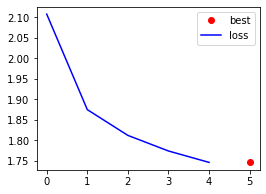

Best epoch so far:  5
Time  163.022 sec

Epoch 6 Batch 598 Loss: 1.5438
Epoch 6 Batch 1196 Loss: 1.8716
Epoch 6 Batch 1794 Loss: 1.7787
Epoch 6 Batch 2392 Loss: 1.8960
Epoch 6 Batch 2990 Loss: 1.6309
Epoch 6 Batch 3588 Loss: 1.9778

*** Epoch 6 Loss 1.7243 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
check point saved!
Best epoch so far:  6
Time  162.760 sec

Epoch 7 Batch 598 Loss: 1.6533
Epoch 7 Batch 1196 Loss: 2.1373
Epoch 7 Batch 1794 Loss: 2.0996
Epoch 7 Batch 2392 Loss: 2.1606
Epoch 7 Batch 2990 Loss: 1.5132
Epoch 7 Batch 3588 Loss: 1.9608

*** Epoch 7 Loss 1.7068 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?

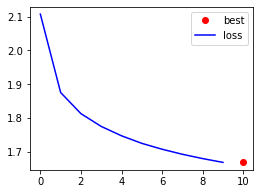

Best epoch so far:  10
Time  162.459 sec

Epoch 11 Batch 598 Loss: 1.4806
Epoch 11 Batch 1196 Loss: 1.8103
Epoch 11 Batch 1794 Loss: 1.6759
Epoch 11 Batch 2392 Loss: 1.8966
Epoch 11 Batch 2990 Loss: 1.5880
Epoch 11 Batch 3588 Loss: 1.9065

*** Epoch 11 Loss 1.6574 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  11
Time  162.680 sec

Epoch 12 Batch 598 Loss: 1.6178
Epoch 12 Batch 1196 Loss: 2.0508
Epoch 12 Batch 1794 Loss: 1.9255
Epoch 12 Batch 2392 Loss: 2.1226
Epoch 12 Batch 2990 Loss: 1.4261
Epoch 12 Batch 3588 Loss: 1.8211

*** Epoch 12 Loss 1.6488 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do it 
%
Greedy| Q: What are you 

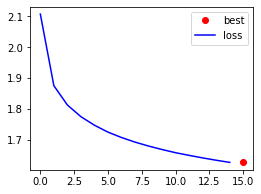

Best epoch so far:  15
Time  162.605 sec

Epoch 16 Batch 598 Loss: 1.4109
Epoch 16 Batch 1196 Loss: 1.8478
Epoch 16 Batch 1794 Loss: 1.6656
Epoch 16 Batch 2392 Loss: 1.9186
Epoch 16 Batch 2990 Loss: 1.6092
Epoch 16 Batch 3588 Loss: 1.7867

*** Epoch 16 Loss 1.6196 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do it 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  16
Time  162.852 sec

Epoch 17 Batch 598 Loss: 1.5183
Epoch 17 Batch 1196 Loss: 1.7239
Epoch 17 Batch 1794 Loss: 1.7204
Epoch 17 Batch 2392 Loss: 1.7734
Epoch 17 Batch 2990 Loss: 1.5448
Epoch 17 Batch 3588 Loss: 1.5984

*** Epoch 17 Loss 1.6133 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: 

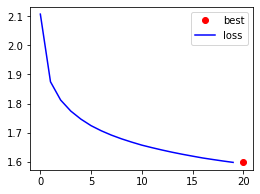

Best epoch so far:  20
Time  162.586 sec

Epoch 21 Batch 598 Loss: 1.3728
Epoch 21 Batch 1196 Loss: 1.8826
Epoch 21 Batch 1794 Loss: 1.7997
Epoch 21 Batch 2392 Loss: 1.9163
Epoch 21 Batch 2990 Loss: 1.6309
Epoch 21 Batch 3588 Loss: 1.8494

*** Epoch 21 Loss 1.5935 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  21
Time  161.725 sec

Epoch 22 Batch 598 Loss: 1.4568
Epoch 22 Batch 1196 Loss: 1.7087
Epoch 22 Batch 1794 Loss: 1.6711
Epoch 22 Batch 2392 Loss: 1.7945
Epoch 22 Batch 2990 Loss: 1.4778
Epoch 22 Batch 3588 Loss: 1.6327

*** Epoch 22 Loss 1.5888 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am 

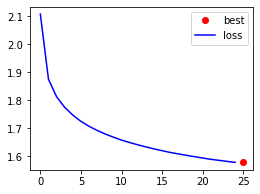

Best epoch so far:  25
Time  162.337 sec

Epoch 26 Batch 598 Loss: 1.3963
Epoch 26 Batch 1196 Loss: 1.9530
Epoch 26 Batch 1794 Loss: 1.8886
Epoch 26 Batch 2392 Loss: 1.8051
Epoch 26 Batch 2990 Loss: 1.6605
Epoch 26 Batch 3588 Loss: 1.9017

*** Epoch 26 Loss 1.5747 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  26
Time  152.498 sec

Epoch 27 Batch 598 Loss: 1.4459
Epoch 27 Batch 1196 Loss: 1.7230
Epoch 27 Batch 1794 Loss: 1.5981
Epoch 27 Batch 2392 Loss: 1.8083
Epoch 27 Batch 2990 Loss: 1.4889
Epoch 27 Batch 3588 Loss: 1.7057

*** Epoch 27 Loss 1.5708 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greed

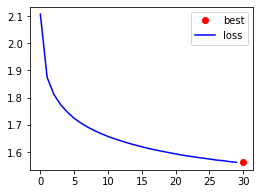

Best epoch so far:  30
Time  153.144 sec

Epoch 31 Batch 598 Loss: 1.2529
Epoch 31 Batch 1196 Loss: 2.0970
Epoch 31 Batch 1794 Loss: 1.8346
Epoch 31 Batch 2392 Loss: 1.8975
Epoch 31 Batch 2990 Loss: 1.6123
Epoch 31 Batch 3588 Loss: 1.9099

*** Epoch 31 Loss 1.5594 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  31
Time  152.503 sec

Epoch 32 Batch 598 Loss: 1.3676
Epoch 32 Batch 1196 Loss: 1.7964
Epoch 32 Batch 1794 Loss: 1.6041
Epoch 32 Batch 2392 Loss: 1.8613
Epoch 32 Batch 2990 Loss: 1.5257
Epoch 32 Batch 3588 Loss: 1.6621

*** Epoch 32 Loss 1.5568 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy|

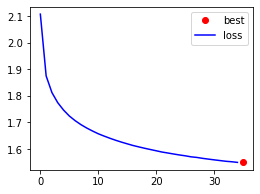

Best epoch so far:  35
Time  157.962 sec

Epoch 36 Batch 598 Loss: 1.3099
Epoch 36 Batch 1196 Loss: 2.0976
Epoch 36 Batch 1794 Loss: 1.8087
Epoch 36 Batch 2392 Loss: 1.9042
Epoch 36 Batch 2990 Loss: 1.6266
Epoch 36 Batch 3588 Loss: 1.7908

*** Epoch 36 Loss 1.5476 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  36
Time  158.766 sec

Epoch 37 Batch 598 Loss: 1.3417
Epoch 37 Batch 1196 Loss: 1.8359
Epoch 37 Batch 1794 Loss: 1.7657
Epoch 37 Batch 2392 Loss: 1.8717
Epoch 37 Batch 2990 Loss: 1.5722
Epoch 37 Batch 3588 Loss: 1.7498

*** Epoch 37 Loss 1.5458 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not going to be a g

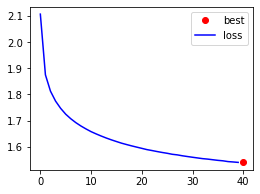

Best epoch so far:  40
Time  158.821 sec

Epoch 41 Batch 598 Loss: 1.3730
Epoch 41 Batch 1196 Loss: 2.0257
Epoch 41 Batch 1794 Loss: 1.9681
Epoch 41 Batch 2392 Loss: 1.8916
Epoch 41 Batch 2990 Loss: 1.6086
Epoch 41 Batch 3588 Loss: 1.8090

*** Epoch 41 Loss 1.5391 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  41
Time  159.112 sec

Epoch 42 Batch 598 Loss: 1.3826
Epoch 42 Batch 1196 Loss: 1.9044
Epoch 42 Batch 1794 Loss: 1.8540
Epoch 42 Batch 2392 Loss: 1.7823
Epoch 42 Batch 2990 Loss: 1.5943
Epoch 42 Batch 3588 Loss: 1.8087

*** Epoch 42 Loss 1.5364 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am 

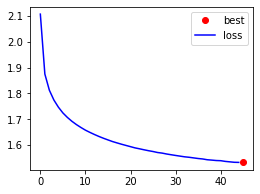

Best epoch so far:  45
Time  152.763 sec

Epoch 46 Batch 598 Loss: 1.4253
Epoch 46 Batch 1196 Loss: 1.9413
Epoch 46 Batch 1794 Loss: 1.9344
Epoch 46 Batch 2392 Loss: 1.8859
Epoch 46 Batch 2990 Loss: 1.5467
Epoch 46 Batch 3588 Loss: 1.8335

*** Epoch 46 Loss 1.5302 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  46
Time  152.467 sec

Epoch 47 Batch 598 Loss: 1.2431
Epoch 47 Batch 1196 Loss: 2.0408
Epoch 47 Batch 1794 Loss: 1.8084
Epoch 47 Batch 2392 Loss: 1.8938
Epoch 47 Batch 2990 Loss: 1.5776
Epoch 47 Batch 3588 Loss: 1.8407

*** Epoch 47 Loss 1.5292 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sur

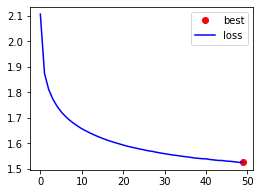

Best epoch so far:  49
Time  152.317 sec

Epoch 51 Batch 598 Loss: 1.4396
Epoch 51 Batch 1196 Loss: 1.9675
Epoch 51 Batch 1794 Loss: 1.9388
Epoch 51 Batch 2392 Loss: 2.0203
Epoch 51 Batch 2990 Loss: 1.5552
Epoch 51 Batch 3588 Loss: 1.9325

*** Epoch 51 Loss 1.5235 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am obsolete 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  51
Time  152.618 sec

Epoch 52 Batch 598 Loss: 1.2939
Epoch 52 Batch 1196 Loss: 2.0558
Epoch 52 Batch 1794 Loss: 1.7930
Epoch 52 Batch 2392 Loss: 1.8983
Epoch 52 Batch 2990 Loss: 1.5872
Epoch 52 Batch 3588 Loss: 1.7530

*** Epoch 52 Loss 1.5222 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sur

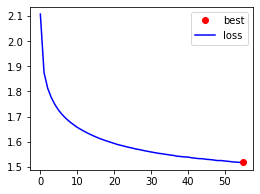

Best epoch so far:  55
Time  152.278 sec

Epoch 56 Batch 598 Loss: 1.4376
Epoch 56 Batch 1196 Loss: 1.9137
Epoch 56 Batch 1794 Loss: 1.9122
Epoch 56 Batch 2392 Loss: 1.9704
Epoch 56 Batch 2990 Loss: 1.5816
Epoch 56 Batch 3588 Loss: 1.7917

*** Epoch 56 Loss 1.5178 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  56
Time  152.677 sec

Epoch 57 Batch 598 Loss: 1.3507
Epoch 57 Batch 1196 Loss: 1.9821
Epoch 57 Batch 1794 Loss: 1.9650
Epoch 57 Batch 2392 Loss: 1.8741
Epoch 57 Batch 2990 Loss: 1.5745
Epoch 57 Batch 3588 Loss: 1.7650

*** Epoch 57 Loss 1.5169 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am 

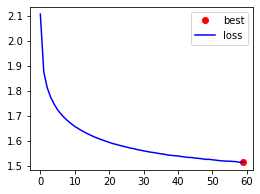

Best epoch so far:  59
Time  152.560 sec

Epoch 61 Batch 598 Loss: 1.4408
Epoch 61 Batch 1196 Loss: 1.8301
Epoch 61 Batch 1794 Loss: 1.8900
Epoch 61 Batch 2392 Loss: 2.0054
Epoch 61 Batch 2990 Loss: 1.5548
Epoch 61 Batch 3588 Loss: 1.7861

*** Epoch 61 Loss 1.5120 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  61
Time  152.543 sec

Epoch 62 Batch 598 Loss: 1.4134
Epoch 62 Batch 1196 Loss: 1.9225
Epoch 62 Batch 1794 Loss: 1.9244
Epoch 62 Batch 2392 Loss: 1.8659
Epoch 62 Batch 2990 Loss: 1.5261
Epoch 62 Batch 3588 Loss: 1.7979

*** Epoch 62 Loss 1.5114 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am 

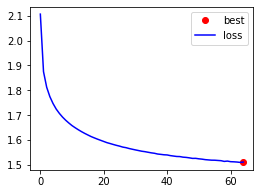

Best epoch so far:  64
Time  152.461 sec

Epoch 66 Batch 598 Loss: 1.4371
Epoch 66 Batch 1196 Loss: 1.7559
Epoch 66 Batch 1794 Loss: 1.9029
Epoch 66 Batch 2392 Loss: 2.0061
Epoch 66 Batch 2990 Loss: 1.4808
Epoch 66 Batch 3588 Loss: 1.7294

*** Epoch 66 Loss 1.5087 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  66
Time  152.363 sec

Epoch 67 Batch 598 Loss: 1.4289
Epoch 67 Batch 1196 Loss: 1.9695
Epoch 67 Batch 1794 Loss: 1.9233
Epoch 67 Batch 2392 Loss: 1.9933
Epoch 67 Batch 2990 Loss: 1.5383
Epoch 67 Batch 3588 Loss: 1.9031

*** Epoch 67 Loss 1.5085 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sur

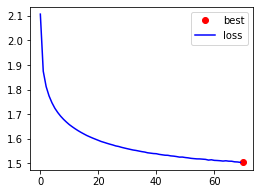

Best epoch so far:  70
Time  152.224 sec

Epoch 71 Batch 598 Loss: 1.4634
Epoch 71 Batch 1196 Loss: 1.7368
Epoch 71 Batch 1794 Loss: 1.8867
Epoch 71 Batch 2392 Loss: 1.9871
Epoch 71 Batch 2990 Loss: 1.3777
Epoch 71 Batch 3588 Loss: 1.6804

*** Epoch 71 Loss 1.5046 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not sure i am not sure i am not sure i am not sure i am 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  70
Time  152.226 sec

Epoch 72 Batch 598 Loss: 1.4215
Epoch 72 Batch 1196 Loss: 1.9093
Epoch 72 Batch 1794 Loss: 1.9021
Epoch 72 Batch 2392 Loss: 1.9583
Epoch 72 Batch 2990 Loss: 1.5501
Epoch 72 Batch 3588 Loss: 1.7767

*** Epoch 72 Loss 1.5052 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: Wh

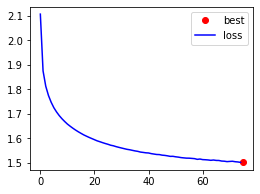

Best epoch so far:  75
Time  155.541 sec

Epoch 76 Batch 598 Loss: 1.4923
Epoch 76 Batch 1196 Loss: 1.7391
Epoch 76 Batch 1794 Loss: 1.8025
Epoch 76 Batch 2392 Loss: 1.9739
Epoch 76 Batch 2990 Loss: 1.3510
Epoch 76 Batch 3588 Loss: 1.6377

*** Epoch 76 Loss 1.4999 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  76
Time  152.544 sec

Epoch 77 Batch 598 Loss: 1.4260
Epoch 77 Batch 1196 Loss: 1.8449
Epoch 77 Batch 1794 Loss: 1.8725
Epoch 77 Batch 2392 Loss: 1.9912
Epoch 77 Batch 2990 Loss: 1.5337
Epoch 77 Batch 3588 Loss: 1.7797

*** Epoch 77 Loss 1.5000 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am 

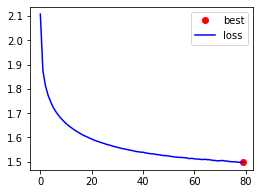

Best epoch so far:  79
Time  152.705 sec

Epoch 81 Batch 598 Loss: 1.4128
Epoch 81 Batch 1196 Loss: 1.6253
Epoch 81 Batch 1794 Loss: 1.5958
Epoch 81 Batch 2392 Loss: 1.6799
Epoch 81 Batch 2990 Loss: 1.4186
Epoch 81 Batch 3588 Loss: 1.3410

*** Epoch 81 Loss 1.4996 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am seventyfour 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  79
Time  152.498 sec

Epoch 82 Batch 598 Loss: 1.4231
Epoch 82 Batch 1196 Loss: 1.8107
Epoch 82 Batch 1794 Loss: 1.9222
Epoch 82 Batch 2392 Loss: 2.0051
Epoch 82 Batch 2990 Loss: 1.4663
Epoch 82 Batch 3588 Loss: 1.7093

*** Epoch 82 Loss 1.5060 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Gree

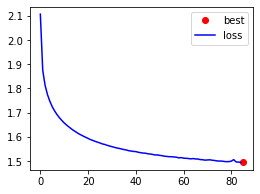

Best epoch so far:  85
Time  152.273 sec

Epoch 86 Batch 598 Loss: 1.3714
Epoch 86 Batch 1196 Loss: 1.6396
Epoch 86 Batch 1794 Loss: 1.5777
Epoch 86 Batch 2392 Loss: 1.6952
Epoch 86 Batch 2990 Loss: 1.3803
Epoch 86 Batch 3588 Loss: 1.4350

*** Epoch 86 Loss 1.4940 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  86
Time  152.172 sec

Epoch 87 Batch 598 Loss: 1.4656
Epoch 87 Batch 1196 Loss: 1.7238
Epoch 87 Batch 1794 Loss: 1.8854
Epoch 87 Batch 2392 Loss: 1.9860
Epoch 87 Batch 2990 Loss: 1.3746
Epoch 87 Batch 3588 Loss: 1.6646

*** Epoch 87 Loss 1.4946 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not going to

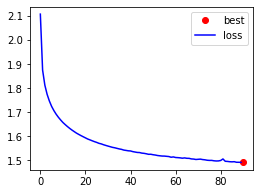

Best epoch so far:  90
Time  155.155 sec

Epoch 91 Batch 598 Loss: 1.3823
Epoch 91 Batch 1196 Loss: 1.6969
Epoch 91 Batch 1794 Loss: 1.5319
Epoch 91 Batch 2392 Loss: 1.7187
Epoch 91 Batch 2990 Loss: 1.4186
Epoch 91 Batch 3588 Loss: 1.4964

*** Epoch 91 Loss 1.4902 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  91
Time  154.373 sec

Epoch 92 Batch 598 Loss: 1.4887
Epoch 92 Batch 1196 Loss: 1.7409
Epoch 92 Batch 1794 Loss: 1.7981
Epoch 92 Batch 2392 Loss: 1.9717
Epoch 92 Batch 2990 Loss: 1.3142
Epoch 92 Batch 3588 Loss: 1.6250

*** Epoch 92 Loss 1.4903 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not sure 

In [ ]:
batch_loss = K.constant(0)
X, y = [], []
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

for ep in range(current_ep,EPOCHS):
    current_ep = ep    
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:     
        
        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q, padding='post')[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a, padding='post')[0]
        
        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :
            batch_loss = train_step(np.array(X), np.array(y), enc_hidden)
            total_loss += batch_loss
            X , y = [], []
            btch += 1
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, K.get_value(batch_loss)))

    epoch_loss =  K.get_value(total_loss) / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)
    
    checkpoint.save(file_prefix = checkpoint_prefix)
    test_bot(k=5)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep 
        print('check point saved!')
    
    if ep % 5 == 0:
        plot_history()
        
    print('Best epoch so far: ',best_ep)
    print('Time  {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)

## Continue training after crash

In [ ]:
current_ep = 94

checkpoint.restore(checkpoint_dir + '/' + str(emb_dim) + "-ckpt-"+ str(current_ep-1))

test_bot()

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################


Epoch 94 Batch 598 Loss: 1.4030
Epoch 94 Batch 1196 Loss: 1.5964
Epoch 94 Batch 1794 Loss: 1.6129
Epoch 94 Batch 2392 Loss: 1.6554
Epoch 94 Batch 2990 Loss: 1.4307
Epoch 94 Batch 3588 Loss: 1.3326

*** Epoch 94 Loss 1.4916 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  94
Time  203.198 sec

Epoch 95 Batch 598 Loss: 1.4262
Epoch 95 Batch 1196 Loss: 1.7400
Epoch 95 Batch 1794 Loss: 1.8716
Epoch 95 Batch 2392 Loss: 1.9833
Epoch 95 Batch 2990 Loss: 1.4645
Epoch 95 Batch 3588 Loss: 1.6909

*** Epoch 95 Loss 1.4896 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favori

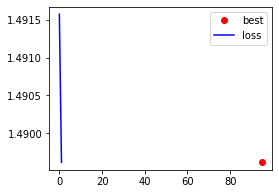

Best epoch so far:  95
Time  159.390 sec

Epoch 96 Batch 598 Loss: 1.3937
Epoch 96 Batch 1196 Loss: 1.9426
Epoch 96 Batch 1794 Loss: 1.8988
Epoch 96 Batch 2392 Loss: 1.9789
Epoch 96 Batch 2990 Loss: 1.5354
Epoch 96 Batch 3588 Loss: 1.8796

*** Epoch 96 Loss 1.4885 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am serving 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  96
Time  159.402 sec

Epoch 97 Batch 598 Loss: 1.2602
Epoch 97 Batch 1196 Loss: 2.0030
Epoch 97 Batch 1794 Loss: 1.7627
Epoch 97 Batch 2392 Loss: 1.8525
Epoch 97 Batch 2990 Loss: 1.5398
Epoch 97 Batch 3588 Loss: 1.7112

*** Epoch 97 Loss 1.4880 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am serving 
%
Greedy| Q: What are you doing ?  A: i am not sure 

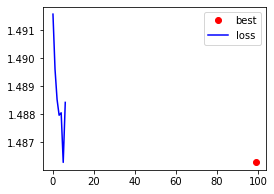

Best epoch so far:  99
Time  160.321 sec

Epoch 101 Batch 598 Loss: 1.4138
Epoch 101 Batch 1196 Loss: 1.8776
Epoch 101 Batch 1794 Loss: 1.8887
Epoch 101 Batch 2392 Loss: 1.9322
Epoch 101 Batch 2990 Loss: 1.5244
Epoch 101 Batch 3588 Loss: 1.7502

*** Epoch 101 Loss 1.4864 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  99
Time  160.561 sec

Epoch 102 Batch 598 Loss: 1.3192
Epoch 102 Batch 1196 Loss: 1.9425
Epoch 102 Batch 1794 Loss: 1.9283
Epoch 102 Batch 2392 Loss: 1.8554
Epoch 102 Batch 2990 Loss: 1.5647
Epoch 102 Batch 3588 Loss: 1.7107

*** Epoch 102 Loss 1.4859 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%


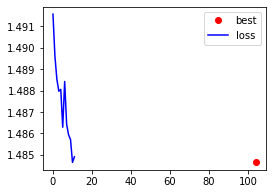

Best epoch so far:  104
Time  159.274 sec

Epoch 106 Batch 598 Loss: 1.3949
Epoch 106 Batch 1196 Loss: 1.8783
Epoch 106 Batch 1794 Loss: 1.8749
Epoch 106 Batch 2392 Loss: 1.9992
Epoch 106 Batch 2990 Loss: 1.5391
Epoch 106 Batch 3588 Loss: 1.7532

*** Epoch 106 Loss 1.4846 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  106
Time  158.828 sec

Epoch 107 Batch 598 Loss: 1.3664
Epoch 107 Batch 1196 Loss: 1.8715
Epoch 107 Batch 1794 Loss: 1.8789
Epoch 107 Batch 2392 Loss: 1.8321
Epoch 107 Batch 2990 Loss: 1.5157
Epoch 107 Batch 3588 Loss: 1.7456

*** Epoch 107 Loss 1.4825 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am serving maria 
%
Greedy| Q: What are you doi

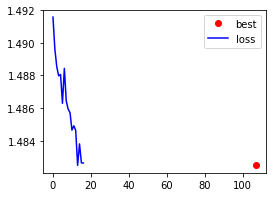

Best epoch so far:  107
Time  159.084 sec

Epoch 111 Batch 598 Loss: 1.4004
Epoch 111 Batch 1196 Loss: 1.7866
Epoch 111 Batch 1794 Loss: 1.9130
Epoch 111 Batch 2392 Loss: 1.9937
Epoch 111 Batch 2990 Loss: 1.4698
Epoch 111 Batch 3588 Loss: 1.6694

*** Epoch 111 Loss 1.4933 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  107
Time  160.038 sec

Epoch 112 Batch 598 Loss: 1.3868
Epoch 112 Batch 1196 Loss: 1.9545
Epoch 112 Batch 1794 Loss: 1.9029
Epoch 112 Batch 2392 Loss: 1.9843
Epoch 112 Batch 2990 Loss: 1.5063
Epoch 112 Batch 3588 Loss: 1.8917

*** Epoch 112 Loss 1.4881 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure i

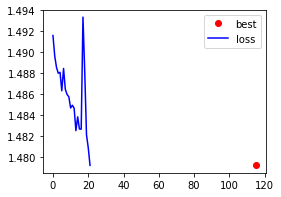

Best epoch so far:  115
Time  158.657 sec

Epoch 116 Batch 598 Loss: 1.4406
Epoch 116 Batch 1196 Loss: 1.7707
Epoch 116 Batch 1794 Loss: 1.8936
Epoch 116 Batch 2392 Loss: 1.9807
Epoch 116 Batch 2990 Loss: 1.3658
Epoch 116 Batch 3588 Loss: 1.6485

*** Epoch 116 Loss 1.4828 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  115
Time  158.132 sec

Epoch 117 Batch 598 Loss: 1.3977
Epoch 117 Batch 1196 Loss: 1.8871
Epoch 117 Batch 1794 Loss: 1.8880
Epoch 117 Batch 2392 Loss: 1.9432
Epoch 117 Batch 2990 Loss: 1.5210
Epoch 117 Batch 3588 Loss: 1.7491

*** Epoch 117 Loss 1.4794 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure i

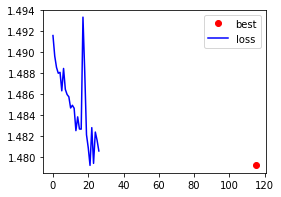

Best epoch so far:  115
Time  158.831 sec

Epoch 121 Batch 598 Loss: 1.4578
Epoch 121 Batch 1196 Loss: 1.7193
Epoch 121 Batch 1794 Loss: 1.8207
Epoch 121 Batch 2392 Loss: 1.9869
Epoch 121 Batch 2990 Loss: 1.3277
Epoch 121 Batch 3588 Loss: 1.5971

*** Epoch 121 Loss 1.4785 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  121
Time  158.694 sec

Epoch 122 Batch 598 Loss: 1.3858
Epoch 122 Batch 1196 Loss: 1.8384
Epoch 122 Batch 1794 Loss: 1.8881
Epoch 122 Batch 2392 Loss: 1.9864
Epoch 122 Batch 2990 Loss: 1.5195
Epoch 122 Batch 3588 Loss: 1.7468

*** Epoch 122 Loss 1.4790 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What ar

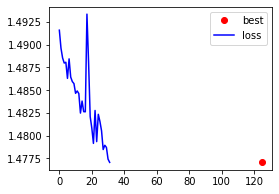

Best epoch so far:  125
Time  159.454 sec

Epoch 126 Batch 598 Loss: 1.4029
Epoch 126 Batch 1196 Loss: 1.5935
Epoch 126 Batch 1794 Loss: 1.5657
Epoch 126 Batch 2392 Loss: 1.6244
Epoch 126 Batch 2990 Loss: 1.3957
Epoch 126 Batch 3588 Loss: 1.3264

*** Epoch 126 Loss 1.4776 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  125
Time  162.319 sec

Epoch 127 Batch 598 Loss: 1.4128
Epoch 127 Batch 1196 Loss: 1.7291
Epoch 127 Batch 1794 Loss: 1.9185
Epoch 127 Batch 2392 Loss: 1.9838
Epoch 127 Batch 2990 Loss: 1.4857
Epoch 127 Batch 3588 Loss: 1.6577

*** Epoch 127 Loss 1.4763 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not

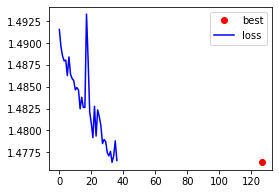

Best epoch so far:  127
Time  158.995 sec

Epoch 131 Batch 598 Loss: 1.3708
Epoch 131 Batch 1196 Loss: 1.6377
Epoch 131 Batch 1794 Loss: 1.5266
Epoch 131 Batch 2392 Loss: 1.6721
Epoch 131 Batch 2990 Loss: 1.3636
Epoch 131 Batch 3588 Loss: 1.4148

*** Epoch 131 Loss 1.4785 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure i am not sure i am not sure i am not sure i am 
%
Greedy| Q: What are you doing ?  A: i am not sure i am not sure i am not sure i am not sure i am 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  127
Time  159.049 sec

Epoch 132 Batch 598 Loss: 1.4384
Epoch 132 Batch 1196 Loss: 1.7631
Epoch 132 Batch 1794 Loss: 1.8984
Epoch 132 Batch 2392 Loss: 1.9727
Epoch 132 Batch 2990 Loss: 1.3563
Epoch 132 Batch 3588 Loss: 1.6402

*** Epoch 132 Loss 1.4773 ***

####################
Greedy| Q: Hello   A: hello 
%
Gre

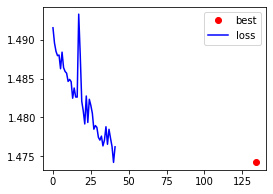

Best epoch so far:  134
Time  160.578 sec

Epoch 136 Batch 598 Loss: 1.3786
Epoch 136 Batch 1196 Loss: 1.6663
Epoch 136 Batch 1794 Loss: 1.5090
Epoch 136 Batch 2392 Loss: 1.7086
Epoch 136 Batch 2990 Loss: 1.3672
Epoch 136 Batch 3588 Loss: 1.5019

*** Epoch 136 Loss 1.4757 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not sure i am not sure 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  134
Time  159.371 sec

Epoch 137 Batch 598 Loss: 1.4576
Epoch 137 Batch 1196 Loss: 1.7042
Epoch 137 Batch 1794 Loss: 1.8004
Epoch 137 Batch 2392 Loss: 1.9767
Epoch 137 Batch 2990 Loss: 1.3108
Epoch 137 Batch 3588 Loss: 1.6232

*** Epoch 137 Loss 1.4749 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i

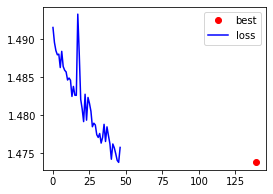

Best epoch so far:  139
Time  161.536 sec



In [ ]:
batch_loss = K.constant(0)
X, y = [], []
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

for ep in range(current_ep,EPOCHS):
    current_ep = ep    
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:     
        
        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q, padding='post')[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a, padding='post')[0]
        
        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :
            batch_loss = train_step(np.array(X), np.array(y), enc_hidden)
            total_loss += batch_loss
            X , y = [], []
            btch += 1
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, K.get_value(batch_loss)))

    epoch_loss =  K.get_value(total_loss) / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)
    
    checkpoint.save(file_prefix = checkpoint_prefix)
    test_bot(k=5)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep 
        print('check point saved!')
    
    if ep % 5 == 0:
        plot_history()
        
    print('Best epoch so far: ',best_ep)
    print('Time  {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)

# Task 3: Investigating the behaviour and the properties of the encoderdecoder network

**Task 3** Let's look at the attention weights and compare them after 5, 50 and 140 epochs. Instead of evaluating by an automatic evaluation method, you can show us 10 predictions for each model. Answer the following questions based on your predictions, giving examples and/or explaining the evidence for your answers.


*   Did the models learn to track local relations between words?

*   Did the models attend to the least frequent tokens in an utterance? Can you see signs of overfitting in models that hang on to the least frequent words?

*   Did the models learn to track some major syntactic relations in the utterances (e.g. subject-verb, verb-object)?

*   Do they learn to encode some other linguistic features? Do they capture part-of-speech tags (POS tags)?

*   What is the effect of more training on the length of responss?

*   In some instances, by the time the decoder has to generate the beginning of a response, it may already forget the most relevant early query tokens. Can you suggest ways to change the training pipeline to make it easier for the model to remember the beginning of the query when it starts to generate the response?





















We determine model learning by checking whether the model pays attention to certain parts of the input question. For example, a model will have learned the local relation between "good boy" in "Are you a good boy" if it pays attention to both "good" and "boy" while answering the question. This is a general observation that applies to all tokens in the answer. That is, if the system answers “Yes I am” but only paid significant attention to “good boy” when outputting “Yes” and “am”, then this still indicates that the model learned the relation “good boy” to answer the question.

The main issue with this approach is that the attention plot only shows how much attention is placed after every token in the answer (decoder output). This makes it hard to track internal relations within the question (encoder input). For example, if we want to determine whether the model is able to learn the dependencies in "Are you a good boy", then it makes sense to plot how much attention the encoder hidden states places to every other part in the question (e.g. does the hidden state of "boy" pay attention to that of "good"), but this isn't possible given that the model doesn't use a self attention mechanism. Nonetheless, the simple approach will suffice.

To start, we first print out a set of 10 predictions for each of the 3 models. Note that function below prints predictions, attention plots, and the average prediction length.

In [ ]:
def print_examples(chkpnt_list, q_list):


  p_len_list = []
  Q_count = 1
  for chkpnt in chkpnt_list:
    checkpoint.restore(checkpoint_dir + '/' + str(emb_dim) + "-ckpt-"+ str(chkpnt))
    for q in q_list:
      print("#"+"="*20+"#")
      print(f"Question {Q_count}")
      print("#"+"="*20+"#") 
      p_len = answer(q, training=False, return_pred_len = True)
      p_len_list.append(p_len)    
      Q_count+=1
      
    print("#"+"="*30+"#")
    print(f"Average prediction length: {sum(p_len_list)/len(p_len_list)}")
    print("#"+"="*30+"#")


q_list = ["Can you play me a sad song",
          "How much money should I deposit into my bank account",

          "Did you finish the game",
          "Did you finish the game that you played last week",

          "Do you believe I saw a man with binoculars",
          "Should I go to New York next year",

          "is a king usually a man",
          "What is your name",

          "Good day do think I should go to the mall this morning or later in the afternoon",
          "Would now be a good time to talk to you or would you prefer to talk later",

          ]


## Task 3a: predictions of 5 epoch model

#====================#
Question 1
#====================#
Input: can you play me a sad song
Predicted answer: i am not 


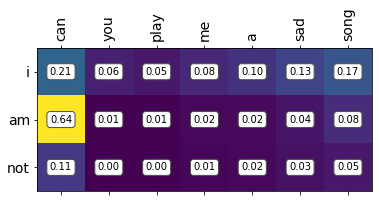

#====================#
Question 2
#====================#
Input: how much money should i deposit into my bank account
Predicted answer: i am not a good time 


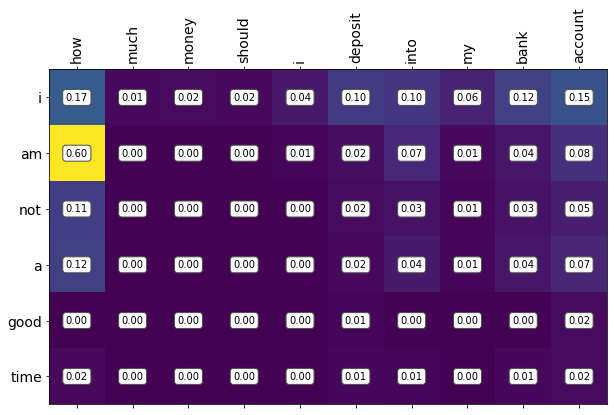

#====================#
Question 3
#====================#
Input: did you finish the game
Predicted answer: i am not going to do 


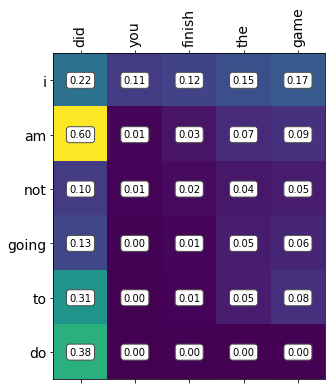

#====================#
Question 4
#====================#
Input: did you finish the game that you played last week
Predicted answer: i am not going to do 


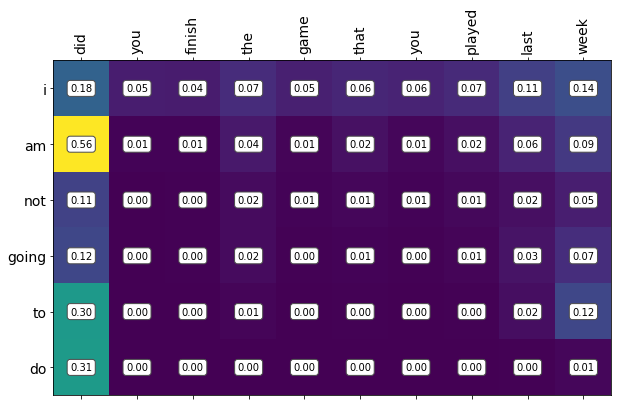

#====================#
Question 5
#====================#
Input: do you believe i saw a man with binoculars
Predicted answer: i am not 


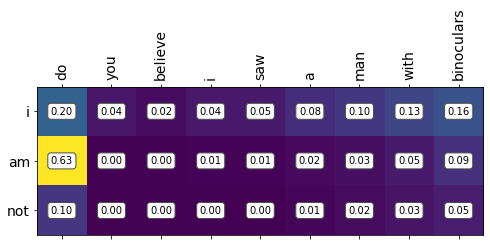

#====================#
Question 6
#====================#
Input: should i go to new york next year
Predicted answer: i am not going to do 


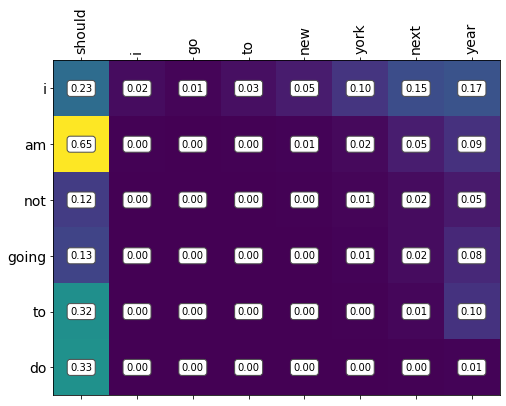

#====================#
Question 7
#====================#
Input: is a king usually a man
Predicted answer: i am not 


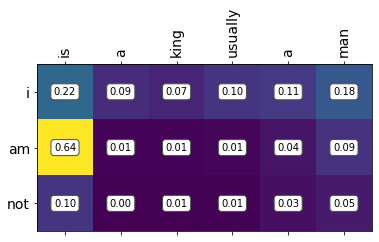

#====================#
Question 8
#====================#
Input: what is your name
Predicted answer: i am not going to do 


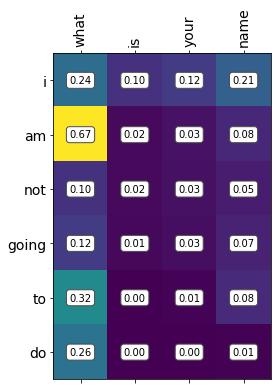

#====================#
Question 9
#====================#
Input: good day do think i should go to the mall this morning or later in the afternoon
Predicted answer: i am i going to the way 


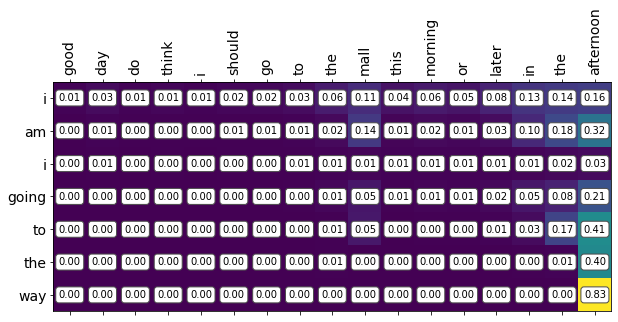

#====================#
Question 10
#====================#
Input: would now be a good time to talk to you or would you prefer to talk later
Predicted answer: i am i going to you 


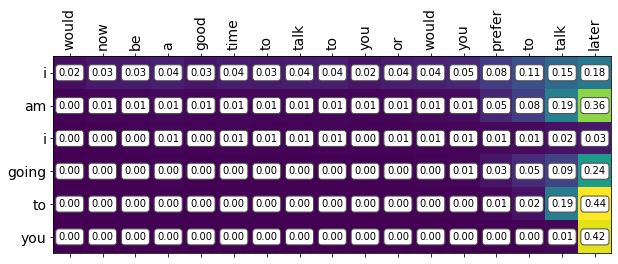

#==============================#
Average prediction length: 5.2
#==============================#


In [ ]:
print_examples([5], q_list)

## Task 3b: predictions of 50 epoch model

#====================#
Question 1
#====================#
Input: can you play me a sad song
Predicted answer: i am sorry 


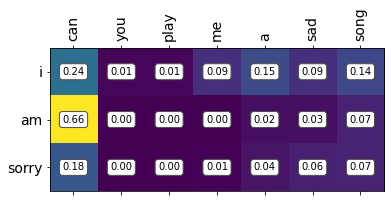

#====================#
Question 2
#====================#
Input: how much money should i deposit into my bank account
Predicted answer: i am not a messenger 


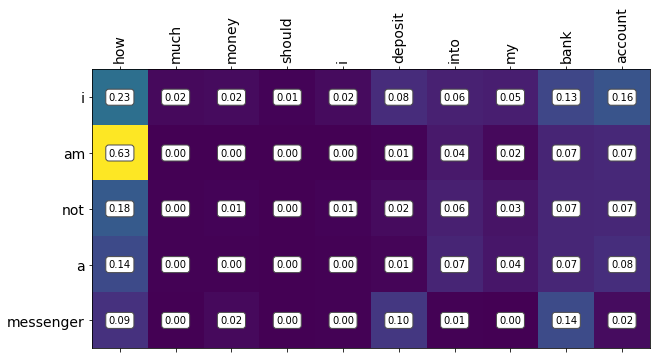

#====================#
Question 3
#====================#
Input: did you finish the game
Predicted answer: i am not 


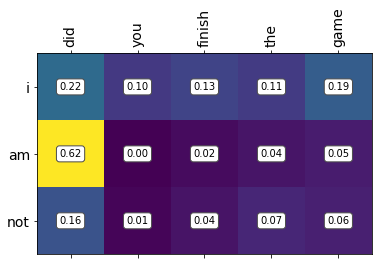

#====================#
Question 4
#====================#
Input: did you finish the game that you played last week
Predicted answer: i am not 


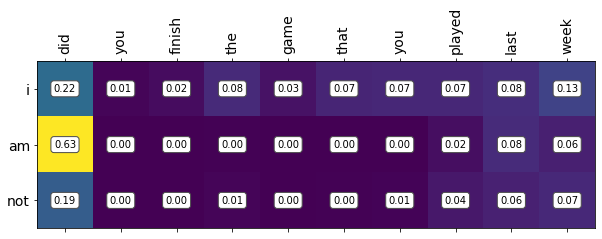

#====================#
Question 5
#====================#
Input: do you believe i saw a man with binoculars
Predicted answer: i am not going to do it 


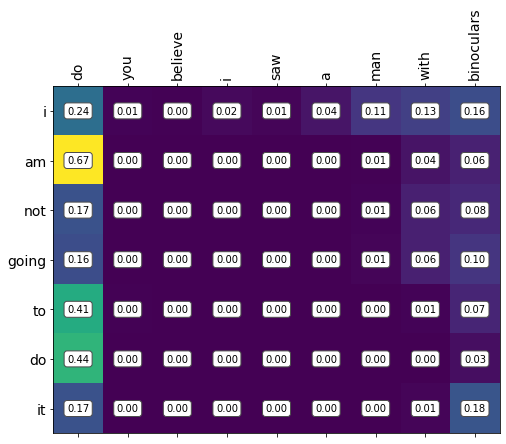

#====================#
Question 6
#====================#
Input: should i go to new york next year
Predicted answer: i am sorry 


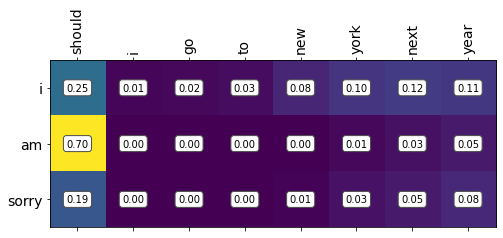

#====================#
Question 7
#====================#
Input: is a king usually a man
Predicted answer: yes 


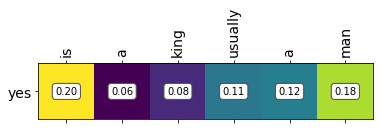

#====================#
Question 8
#====================#
Input: what is your name
Predicted answer: costello 


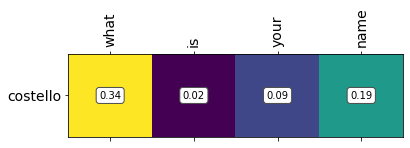

#====================#
Question 9
#====================#
Input: good day do think i should go to the mall this morning or later in the afternoon
Predicted answer: i am 


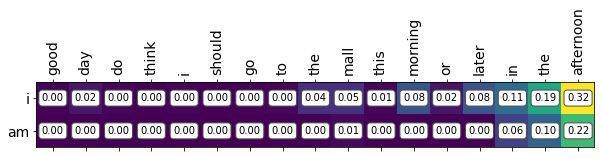

#====================#
Question 10
#====================#
Input: would now be a good time to talk to you or would you prefer to talk later
Predicted answer: i am 


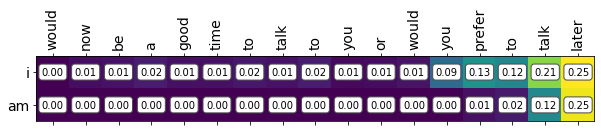

#==============================#
Average prediction length: 3.0
#==============================#


In [ ]:
print_examples([50], q_list)

## Task 3c: predictions of 140 epoch model

#====================#
Question 1
#====================#
Input: can you play me a sad song
Predicted answer: i am sorry 


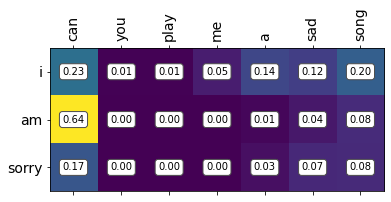

#====================#
Question 2
#====================#
Input: how much money should i deposit into my bank account
Predicted answer: i am not a messenger 


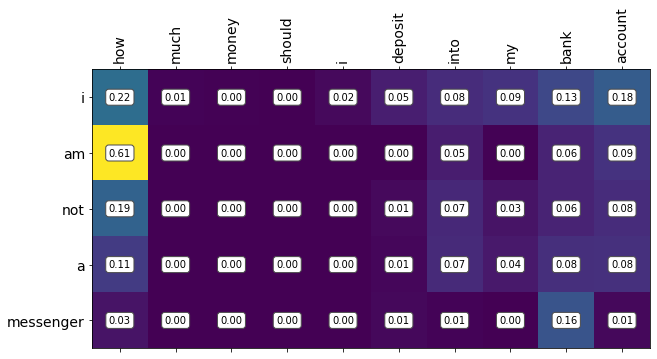

#====================#
Question 3
#====================#
Input: did you finish the game
Predicted answer: i am not 


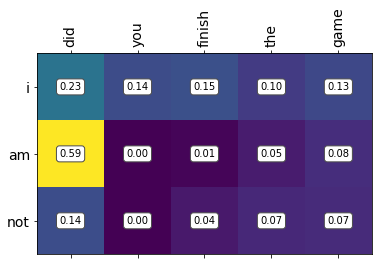

#====================#
Question 4
#====================#
Input: did you finish the game that you played last week
Predicted answer: i am sorry 


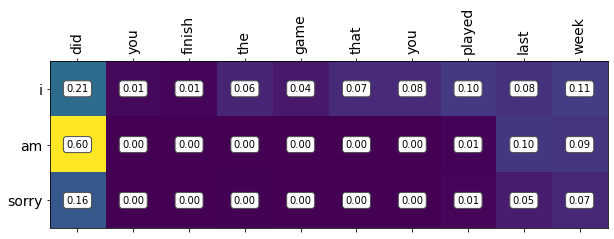

#====================#
Question 5
#====================#
Input: do you believe i saw a man with binoculars
Predicted answer: i am not 


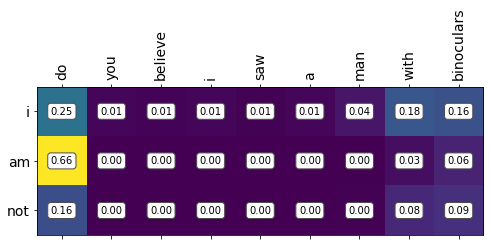

#====================#
Question 6
#====================#
Input: should i go to new york next year
Predicted answer: i am sorry 


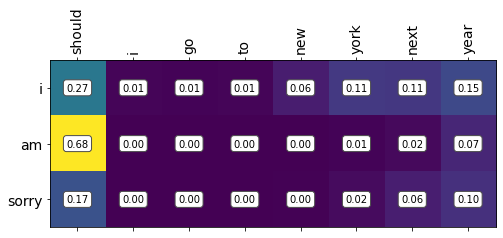

#====================#
Question 7
#====================#
Input: is a king usually a man
Predicted answer: yes 


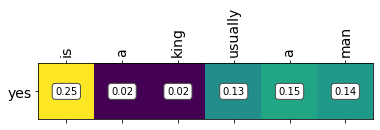

#====================#
Question 8
#====================#
Input: what is your name
Predicted answer: valdes 


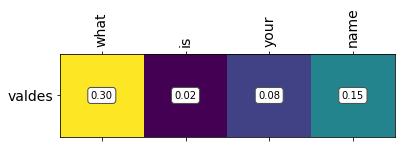

#====================#
Question 9
#====================#
Input: good day do think i should go to the mall this morning or later in the afternoon
Predicted answer: you are you 


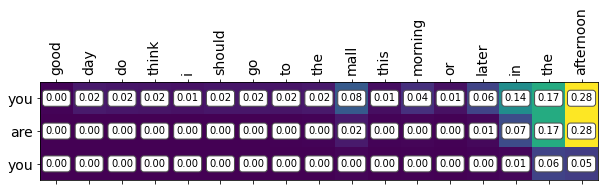

#====================#
Question 10
#====================#
Input: would now be a good time to talk to you or would you prefer to talk later
Predicted answer: i am i 


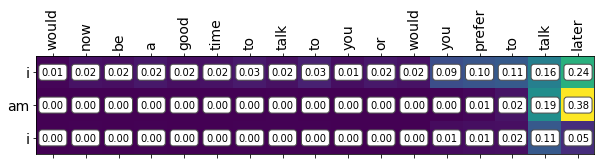

#==============================#
Average prediction length: 2.8
#==============================#


In [ ]:
print_examples([140], q_list)

## Task 3d: Answers to questions

### 1) Did the models learn to track local relations between words?

We define local relations to be syntactic or semantic relations between nearby words in the question. In Q1, all three models paid attention to the last three words “a sad song”, indicating that they somewhat learned that these three are related. The same goes for Q6’s semantic relation “New York”, though the attention paid to these tokens were lower because they are not in the end of the question. However, the model had trouble paying attention to non-adjacent relations. For instance, in Q2 the models were somewhat able to to pay attention to “deposit”, “bank”, and “account” but not to the non-adjacent word “money”, and in Q1 the models didn’t pay much attention “play” despite the word being syntactially related to “a sad song”. 

Therefore, the models were able to learn strict adjacent local relations but had trouble learning non-adjacent ones. Moreover, it is hard to tell whether the models learned syntactic or semantic relations. That is, the models could have just learned these relations through pure adjacency rather than learning a linguistic structure. Lastly, relations situated in the end of the sentence are generally given more attention than those in the middle.



### 2) Did the models attend to the least frequent tokens in an utterance? Can you see signs of overfitting in models that hang on to the least frequent words?

The models attended to infrequent utterance in the question, but mostly towards the first word in the sequence. This could be because the model was trained on question-answer pairs, and the first word in a question usually instigates the query (e.g., what, how, where, etc). This is apparent as the first token always has the most attention for Q1-Q8 over all models. The only exceptions being Q9 and Q10 because those questions were long, and hence the decoder probably forgot the start of those questions. However, the models paid most attention to the end tokens of Q9 and Q10 (“afternoon” and “later”), which were also infrequent tokens for those questions.

One possible sign of overfit is that the attention paid to the first token is significantly higher than models trained on lesser epochs. However, this wasn’t apparent during testing as the 140-epoch model actually paid slightly less attention to the starting question token than the 50-epoch model. If 50-epochs is already overfitting, then training on more epochs should’ve made the overfit worse (e.g. higher attention to start tokens). 

Another sign is “over-answering” where the decoder stopped an answer in an early-epoch model but then mistakenly continued it in a later-epoch model. This is what occurred in Q9 and Q10, as the 140 epoch model’s answer just repeats the first word in the reply. For example, in Q10 the 50-epoch model replies “I am” while the 140-epoch model replies “I am I”. Attention plots show that the second reply of the 140 epoch model (Q9: “are”, Q10: “am”) paid more attention to the last word in sentence, which might have caused the “over answering”. However, repetitiveness can also just be a side effect of greedy decoding, therefore it’d be best to redo attention plots using beam search to confirm that the over answering is truly a result of “hanging on” to the last word in the sequence.



### 3) Did the models learn to track some major syntactic relations in the utterances (e.g. subject-verb, verb-object)?

the models seem to have learned some syntactic relations, but still pay more attention to relations at the end of the sequence. For example in Q3 the models tended to pay attention to the subect-verb pair (you, finish), the verb-object pair (finish, game), and the determinant-noun pair (the, game), but the latter had the highest attention scores because they were at the end of the sentence. Moreover, attention for the middle tokens dropped after outputting more words for the answer.

Q4 is just an expansion of Q3, but only the 5-epoch model still paid attention to (you, finish). In contrast, all three models paid attention to the additional pairs like (you, played) which occur much later in the sentence. Therefore, the models did learn syntactic relations except attention is much higher for those relations near the end of the question. Moreover, attention of the middle question tokens drops after each successive word in the answer. 



### 4) Do they learn to encode some other linguistic features? Do they capture part-of-speech tags (POS tags)?

Relating back to the local relations question, it’s hard to tell whether the models learned relations purely due to adjacency or through actually learning syntactic structure. To test whether the models learned the latter, and therefore possibly POS tags as well, we fed the models an ambiguous question that can be interpretted as “Do you believe **i saw** a man **with binoculars**” or “Do you believe i saw a **man with binoculars**”. If the model pays fairly equal attention to “I saw” and “with binoculars”, then it could be an indication that the model learned POS tags because the words are non adjacent. However, the results of Q5 showed that the models didn’t pay too much attention to “I saw”, instead paying more attention to the ending phrase “man with binoculars”. Therefore there’s no substantial proof to show that the model explicitly learned POS tags.

On the other hand, we also tested semantic representation by asking the models questions about gender (Q7 and Q8). The results showed the 140 epoch model answered the male question correctly and the female question incorrectly, yet both answers were discernable (e.g., “yes” and “no”). Despite getting one answer wrong, this result may potentially indicate that the model is somewhat able to encode semantic information on gender, hence allowing the decoder to pick the right answer. However, this is inconclusive and requires further testing.

In summary, there’s no sufficient evidence to suggest that the models learned POS tags, but the 140 epoch model might’ve learned some semantic gender information in relation to males, but requires more testing. 



### 5) What is the effect of more training on the length of responses?

Empirically, our testing showed that on average, more training resulted in shorter responses. Of note, there is a bigger differenec between the 5-epoch model and the 50-epoch model than the 140-epoch model and the 50-epoch model. The reason is that the 5 epoch model tends to greedily encode the answer “I am not going to do”, which is long compared to how the other models replied.

### 6) In some instances, by the time the decoder has to generate the beginning of a response, it may already forget the most relevant early query tokens. Can you suggest ways to change the training pipeline to make it easier for the model to remember the beginning of the query when it starts to generate the response?

If the data specification remains the same, wherein observations are question and answer pairs, then one way to improve the decoder "memory" of the earlier query tokens is by using an LSTM. Unlike GRUs, LSTMs have a dedicate long term cell state as a well as a memory state for the previous hidden state. The former could allow LSTMs to remember longer term dependencies, with the drawback that they involve more parameters than GRUs.

Of course another option would be to change the model into a transformer, as LSTMs and GRUs still suffer from the typical RNN bottlenecking effect (i.e., they will still eventually forget things in the further past). Transformers, due to multi-head attention, are resilient to reccurrent information bottleneck while also being capable of learning different types of dependencies (i.e., because each head will learn a different type), but the drawkback is that it will be much harder to train. It'd be best to start this approach by fine tuning a pretrained transformer in order to avoid training such a big architecture from scratch.

One middle ground approach could be to implement an LSTM encoder with a self attention mechanism along with either Bahdanau or Luong attention. The idea is that self attention will help the encoder retain information from the far-ends of the input question, therefore improving the representation to be fed into the decoder. An example of this was done by (Cheng, et al., 2016), where they implemented self-attention through a modified LSTM unit called Long Short-Term Memory-Network (LSTMN) that replaces the cell state with a memory network which induces relations among tokens in either the encoder or decoder. Also, using self-attention, whether on its own or through a transformer, allows us to track internal relations and dependencies in the question, as alluded to earlier.


    Source:
    Cheng, J., Dong, L. & Lapata, M., 2016. Long Short-Term Memory-Networks for Machine Reading. [Online] 
    Available at: https://arxiv.org/abs/1601.06733
